In [13]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [14]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsM_0005.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.95140754, 4.11830429)>


In [15]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1V Reduced')
file = 'reduceducdM_0005.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a-625
b = b-625
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[105.69271215 132.26499396 585.15571754 161.9471829  272.64591245
 202.11580924 652.95375142 534.06807746 704.48421382 600.96238731]
[564.11800521 667.7277727  548.42377026 487.24507471 512.46511866
 498.57201386 115.45868131 138.5148475  202.96547389 378.16195355]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
445 104.91946 563.31598 0.55766646 ...   0 333.96464 20.130017 -3.2596103
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
535 131.59877 666.63233 0.52939487 ...   0 244.19426 15.739511 -2.9924781
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
432 580.23709 547.84422 0.61370345 ...   0 272.88337 15.559374 -2.9799803
 id xcentroid ycentroid sharpness  ... sky   peak      flux      mag

In [20]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=4) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

In [21]:
print(mags)

[-10.42107063806954, -10.315582921603323, -10.333723792318475, -10.582550133149045, -11.183611447906966, -10.760864371830607, -10.588881774535084, -10.206968070573517, -10.30159250479201, -10.443716080324199]


[  0.39699317 -16.39522702]
[[ 0.00080103 -0.0117053 ]
 [-0.0117053   0.17153537]]
Beta: [  0.41098354 -16.58538681]
Beta Std Error: [0.02893836 0.42909021]
Beta Covariance: [[ 6.41820158e-05 -9.50874684e-04]
 [-9.50874684e-04  1.41111611e-02]]
Residual Variance: 13.047715068273877
Inverse Condition #: 0.016317911945380927
Reason(s) for Halting:
  Sum of squares convergence


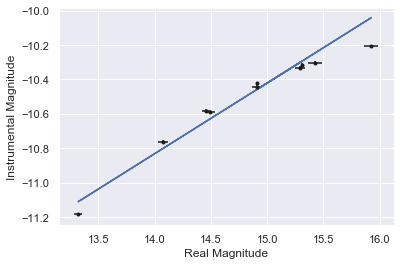

In [22]:
#mags = np.array([-10.42107064,-10.58255013,-11.183611447906966,
        #-10.76086437,-10.58888177,-10.44371608])
#realmag = np.array([14.909,14.459,13.321,14.072,14.495,14.909])

#realmagerrors = [0.0032,0.042,0.037,0.044,0.039,0.043]
#magserrors = [0.008943586473747897,
              #0.008302632429170585,0.006295113263776431, 0.007648089538248899,
              #0.00827845863640818, 0.008850801932405897]
        
        
mags = np.array(mags)
realmag = [14.909,15.313,15.289,14.459,13.321,14.072,14.495,15.924,15.427,14.909]
realmag = np.array(realmag)
realmagerrors = [0.0032,0.0074,0.044,0.042,0.037,0.044,0.039,0.063,0.062,0.043]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [23]:
xref = 395
yref = 352

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -5<(k-xref)<5 and -5<(l-yref)<5:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
290 600.18223  376.8746 0.58237742 ...   0  368.5563 21.600998 -3.3361845
274 394.10847 352.12974 0.54689764 ...   0 16761.454 1022.3903 -7.5240418


In [33]:
sourcemag = []
sourcemagerror = []
position = [(394.10847,352.12974)]
aperture = CircularAperture(position[0], r=4) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-13.469806823152277]


In [34]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.580790216459971 +/- 1.172606803558154
